C:\Users\alanl\AppData\Local\Temp\ipykernel_26560\2134454339.py:24: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  parser = lambda y,m,d,H,M: pd.datetime.strptime(f"{y}.{m}.{d}.{H}.{M}", "%Y.%m.%d.%H.%M")
C:\Users\alanl\AppData\Local\Temp\ipykernel_26560\2134454339.py:26: FutureWarning: 
        Use pd.to_datetime instead.

  wave_data_2 = pd.read_csv(file, skiprows = 2, parse_dates={"Time":[0,1,2,3,4]}, date_parser=parser)


1769357.525218575
[-14546000.         -13989187.47664947 -13473620.32539897
 -12996243.33350037 -12554227.60026092 -12144953.77318736]


C:\Users\alanl\AppData\Local\Temp\ipykernel_26560\2134454339.py:54: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  dfs_resampled = [df.loc[:end_date].resample('60min').mean().interpolate() for df in dfs]
C:\Users\alanl\AppData\Local\Temp\ipykernel_26560\2134454339.py:54: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfs_resampled = [df.loc[:end_date].resample('60min').mean().interpolate() for df in dfs]


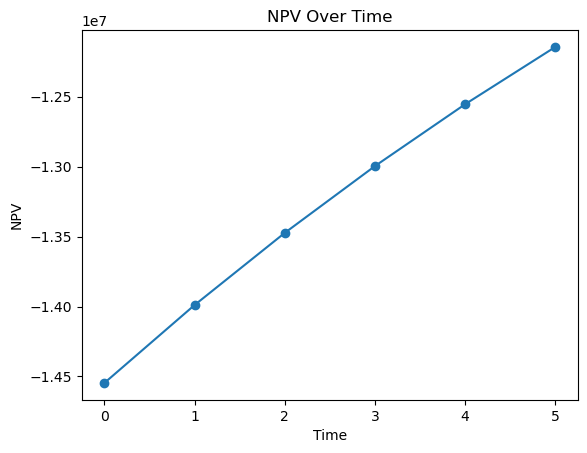

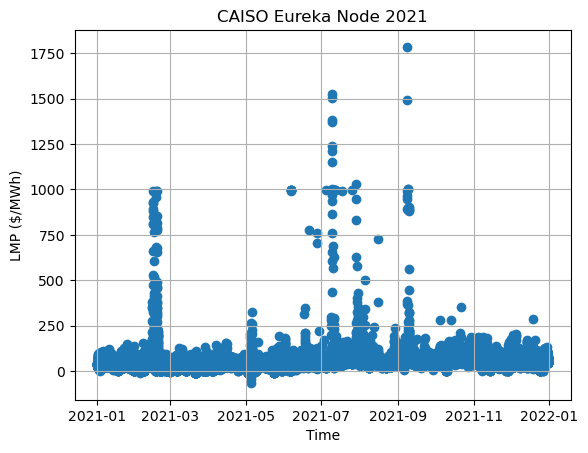

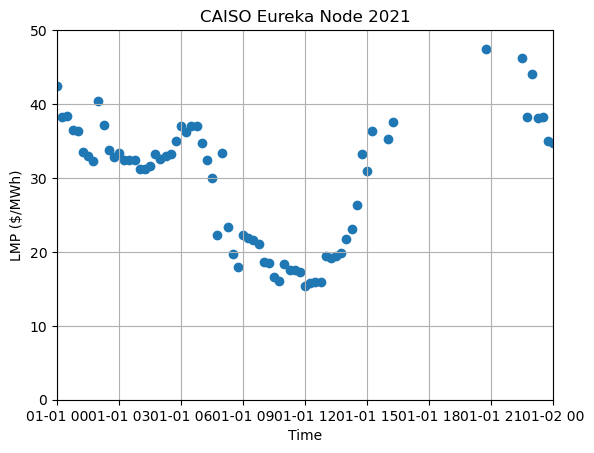

In [53]:
%matplotlib inline
#import mhkit
import gridstatus
import numpy as np
import numpy_financial as npf
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt
#import PySAM.Pvwattsv8 as pv
 #import PySAM.Windpower as wd

## NDBC data
#3ndbc_data_file = 'NDBC-46022-2021-spectrum.txt'
# downloaded from https://www.ndbc.noaa.gov/download_data.php?filename=46022w2021.txt.gz&dir=data/historical/swden/
#[wave_data,meta] = mhkit.wave.io.ndbc.read_file(ndbc_data_file)
#depth = 419 # m
#J = mhkit.wave.resource.energy_flux(wave_data.T,depth) # energy flux, W/m

# SAM wave 3-hourly data
url = 'https://raw.githubusercontent.com/NREL/SAM/develop/deploy/wave_resource_ts/lat40.84_lon-124.25__2010.csv'
download = requests.get(url).content
file = io.StringIO(download.decode('utf-8'))
parser = lambda y,m,d,H,M: pd.datetime.strptime(f"{y}.{m}.{d}.{H}.{M}", "%Y.%m.%d.%H.%M")

wave_data_2 = pd.read_csv(file, skiprows = 2, parse_dates={"Time":[0,1,2,3,4]}, date_parser=parser)
wave_data_2 = wave_data_2[['Time','Significant Wave Height','Energy Period']].set_index("Time")
wave_data_2.index = wave_data_2.index.tz_localize('US/Pacific') + pd.offsets.DateOffset(years=11) # fake it starting in 2021
wave_data_2.head()

# CAISO data
caiso = gridstatus.CAISO()
start = pd.Timestamp("Jan 1, 2021").normalize()
end = pd.Timestamp("Dec 31, 2021").normalize()
#lmp = caiso.get_lmp(start=start, end=end, market='REAL_TIME_HOURLY', 
#                    locations=["EUREKAA_6_N001"])
lmp = pd.read_csv('lmp-eureka-2021.csv',index_col=1)
lmp.index = pd.to_datetime(lmp.index,utc=True).tz_convert('US/Pacific')

rho = 1025
g = 9.8
coeff = rho*(g**2)/(64*np.pi)
wave_data_2["J"] = coeff*wave_data_2["Significant Wave Height"]**2*wave_data_2["Energy Period"]
CW = 10*50 # total capture width of WEC, m (assuming array of 50, with 10m each)
wave_data_2["P"] = wave_data_2["J"] * CW # power of WEC, W
#print(len(wave_data_2["P"]))
#print(wave_data_2["J"])
#print(wave_data_2["P"])
#len_wd2p = len(wave_data_2["P"])
#print(len_wd2p)

dfs = [lmp, wave_data_2["P"]]
end_date = pd.Timestamp("Dec 31, 2021").normalize()
dfs_resampled = [df.loc[:end_date].resample('60min').mean().interpolate() for df in dfs]
#print(dfs_resampled)

resampled_lmp = dfs_resampled[0]["LMP"]  # Access the resampled 'lmp' DataFrame
resampled_wave_power = dfs_resampled[1]
resampled_wave_power = resampled_wave_power.iloc[:-1]
#print(resampled_lmp)
#print(resampled_wave_power)

W_to_MWh = 15/60 * 10**-6 # for 15min timestep
revenue = W_to_MWh * np.dot(resampled_wave_power, resampled_lmp)
print(revenue)

#extract the lMP data as well as Energy Data
#energy_data = lmp.iloc[:, 5].tolist()
#lmp_data = lmp.iloc[:, 4].tolist()
#print(energy_data)
#lmp_length= len(lmp_data)
#print(lmp_length)

#elec_revenue_yr = np.dot(energy_data, lmp_data)
#print(elec_revenue_yr)
#was unsure about where cost data is in the csv; used prior estimates
rate = 0.08 # interest rate
N_WEC = 1

#capex computation
development     = 4553000;
infrastructure  = 990000;
mooring         = N_WEC * 525000
pto             = N_WEC * 623000
profitmargin    = 356000
installation    = 5909000
contingency     = 1590000
capex = development + infrastructure + mooring + pto + profitmargin + installation + contingency

#opex computation
operations = N_WEC * 27000;
postinstall = 710000;
shoreoperations = 142000;
replacement = N_WEC * 54000;
consumables = N_WEC * 8000;
insurance = (.8 + .2*N_WEC) * 227000;
opex = operations + postinstall + shoreoperations + replacement + consumables + insurance

profit_year = revenue - opex

lifetime = 5 #years
cashflow_total = profit_year * lifetime
initial_capex = -1*capex

cashflow = np.full( (lifetime,), profit_year)
#transform into python list to insert the initial capex value
cashflow_list=cashflow.tolist()
cashflow_list.insert(0,initial_capex)
cashflow=np.array(cashflow_list)
#print(cashflow)
npv_values = np.zeros(len(cashflow))
for i in range(len(cashflow)):
     npv_values[i] = (npf.npv(rate, cashflow[:i+1])) 
time = np.arange(len(cashflow))
for t in (time):
     npv_values[t] = npf.npv(rate, cashflow[:t+1])
#print(npv_values)

plt.plot(time, npv_values, marker = 'o')
plt.xlabel("Time")
plt.ylabel("NPV")
plt.title("NPV Over Time")
plt.show()

# plot CAISO data
for i in range(0,2):
    fig, ax = plt.subplots()
    ax.scatter(lmp.index, lmp["LMP"])
    ax.set(xlabel='Time', ylabel='LMP ($/MWh)', title='CAISO Eureka Node 2021')
    ax.grid()
    if i==1:
        plt.xlim([lmp.index[0], lmp.index[24*4]])
        plt.ylim([0,50])
    #plt.savefig('figs/caiso-data-'+f"{i}"+'.png')
